# PBMC data integration

We apply uniPort to integrate transcriptomic and epigenomic data using scATAC (gene activity matrix) and scRNA datasets profiled from peripheral blood mononuclear cells (PBMC), including 11259 paired cells with 19434 genes in scATAC and 26187 genes in scRNA.The PBMC data consists of paired scATAC-seq and scRNA-seq profiles, but we treat them as unpaired.

In [12]:
import uniport as up
import numpy as np
import pandas as pd
import scanpy as sc
print(up.__version__)

1.1.1


### Data preprocessing
Read cell types for both scATAC-seq and scRNA-seq

In [13]:
labels = pd.read_csv('PBMC/meta.txt', sep='\t')
celltype = labels['cluster'].values

Read gene activity matrix and RNA counts into `AnnData` objects using `load_file` fucntion in uniport.   

In [14]:
adata_rna = up.load_file('PBMC/rna.h5ad')
adata_atac = up.load_file('PBMC/atac_meastro.h5ad')
print(adata_rna)
print(adata_atac)

AnnData object with n_obs × n_vars = 11259 × 11942
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 11259 × 28307


Add 'cell_type', 'domain_id' and 'source' to the `AnnData`objects.\
'cell_type' stores cell label annotations. \
'domain_id' identifies the modality using a number category. \
'source' identifies the modality using its name.

In [15]:
adata_atac.obs['cell_type'] = celltype
adata_atac.obs['domain_id'] = 0
adata_atac.obs['domain_id'] = adata_atac.obs['domain_id'].astype('category')
adata_atac.obs['source'] = 'ATAC'

adata_rna.obs['cell_type'] = celltype
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

Filter cells and features using `filter_data` function in uniport. 

In [16]:
# up.filter_data(adata_atac, min_features=3, min_cells=200)
# up.filter_data(adata_rna, min_features=3, min_cells=200)
# print(adata_atac)
# print(adata_rna)

Concatenate scATAC-seq and scRNA-seq with common genes using `AnnData.concatenate`.

In [17]:
adata_cm = adata_atac.concatenate(adata_rna, join='inner', batch_key='domain_id')

Preprocess data with common genes. Select 2,000 highly variable common genes. \
Scale data using `batch_scale` function in uniport (modified from [SCALEX](https://scalex.readthedocs.io/en/latest/api/index.html#preprocessing)).

In [18]:
# sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_cm)
# sc.pp.scale(adata_cm)
print(adata_cm.obs)

                      cell_type domain_id source  n_genes
AAACAGCCAAGGAATC.1-0  CD4 Naive         0   ATAC      NaN
AAACAGCCAATCCCTT.1-0   CD4 Tmem         0   ATAC      NaN
AAACAGCCAATGCGCT.1-0  CD4 Naive         0   ATAC      NaN
AAACAGCCACACTAAT.1-0  CD8 Naive         0   ATAC      NaN
AAACAGCCACCAACCG.1-0  CD8 Naive         0   ATAC      NaN
...                         ...       ...    ...      ...
TTTGTTGGTGACATGC.1-1  CD8 Naive         1    RNA   1586.0
TTTGTTGGTGTTAAAC.1-1  CD8 Naive         1    RNA   1525.0
TTTGTTGGTTAGGATT.1-1         NK         1    RNA   2024.0
TTTGTTGGTTGGTTAG.1-1   CD4 Tmem         1    RNA   1620.0
TTTGTTGGTTTGCAGA.1-1   CD8 Tmem         1    RNA   1920.0

[22518 rows x 4 columns]


Preprocess scRNA-seq data. Select 2,000 highly variable genes as RNA specific.

In [19]:
# sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_rna)
# sc.pp.scale(adata_rna)

Preprocess scATAC-seq data.
Select 2,000 highly variable genes as ATAC speicifc.

In [20]:
# sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_atac)
sc.pp.log1p(adata_atac)
sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_atac)
# sc.pp.scale(adata_atac)

Save the preprocessed data for integration.

### Integration with specific genes and optimal transport loss
Integrate the scATAC-seq and scRNA-seq data using both common and dataset-specific genes by `Run` function in uniport. The latent representations of data are stored in `adata.obs['latent']`.

In [21]:
adata = up.Run(adatas=[adata_atac,adata_rna], adata_cm=adata_cm, lambda_s=1.0)

Device: cuda
Dataset 0: ATAC
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'




Epochs: 100%|████████████████████████████████████████████████████████████████████████████| 345/345 [10:09<00:00,  1.77s/it, recloss=1148.08,klloss=9.01,otloss=6.87]


Before integration. Visualize the data using UMAP according to their cell types and sources.

After integration

... storing 'cell_type' as categorical
... storing 'source' as categorical


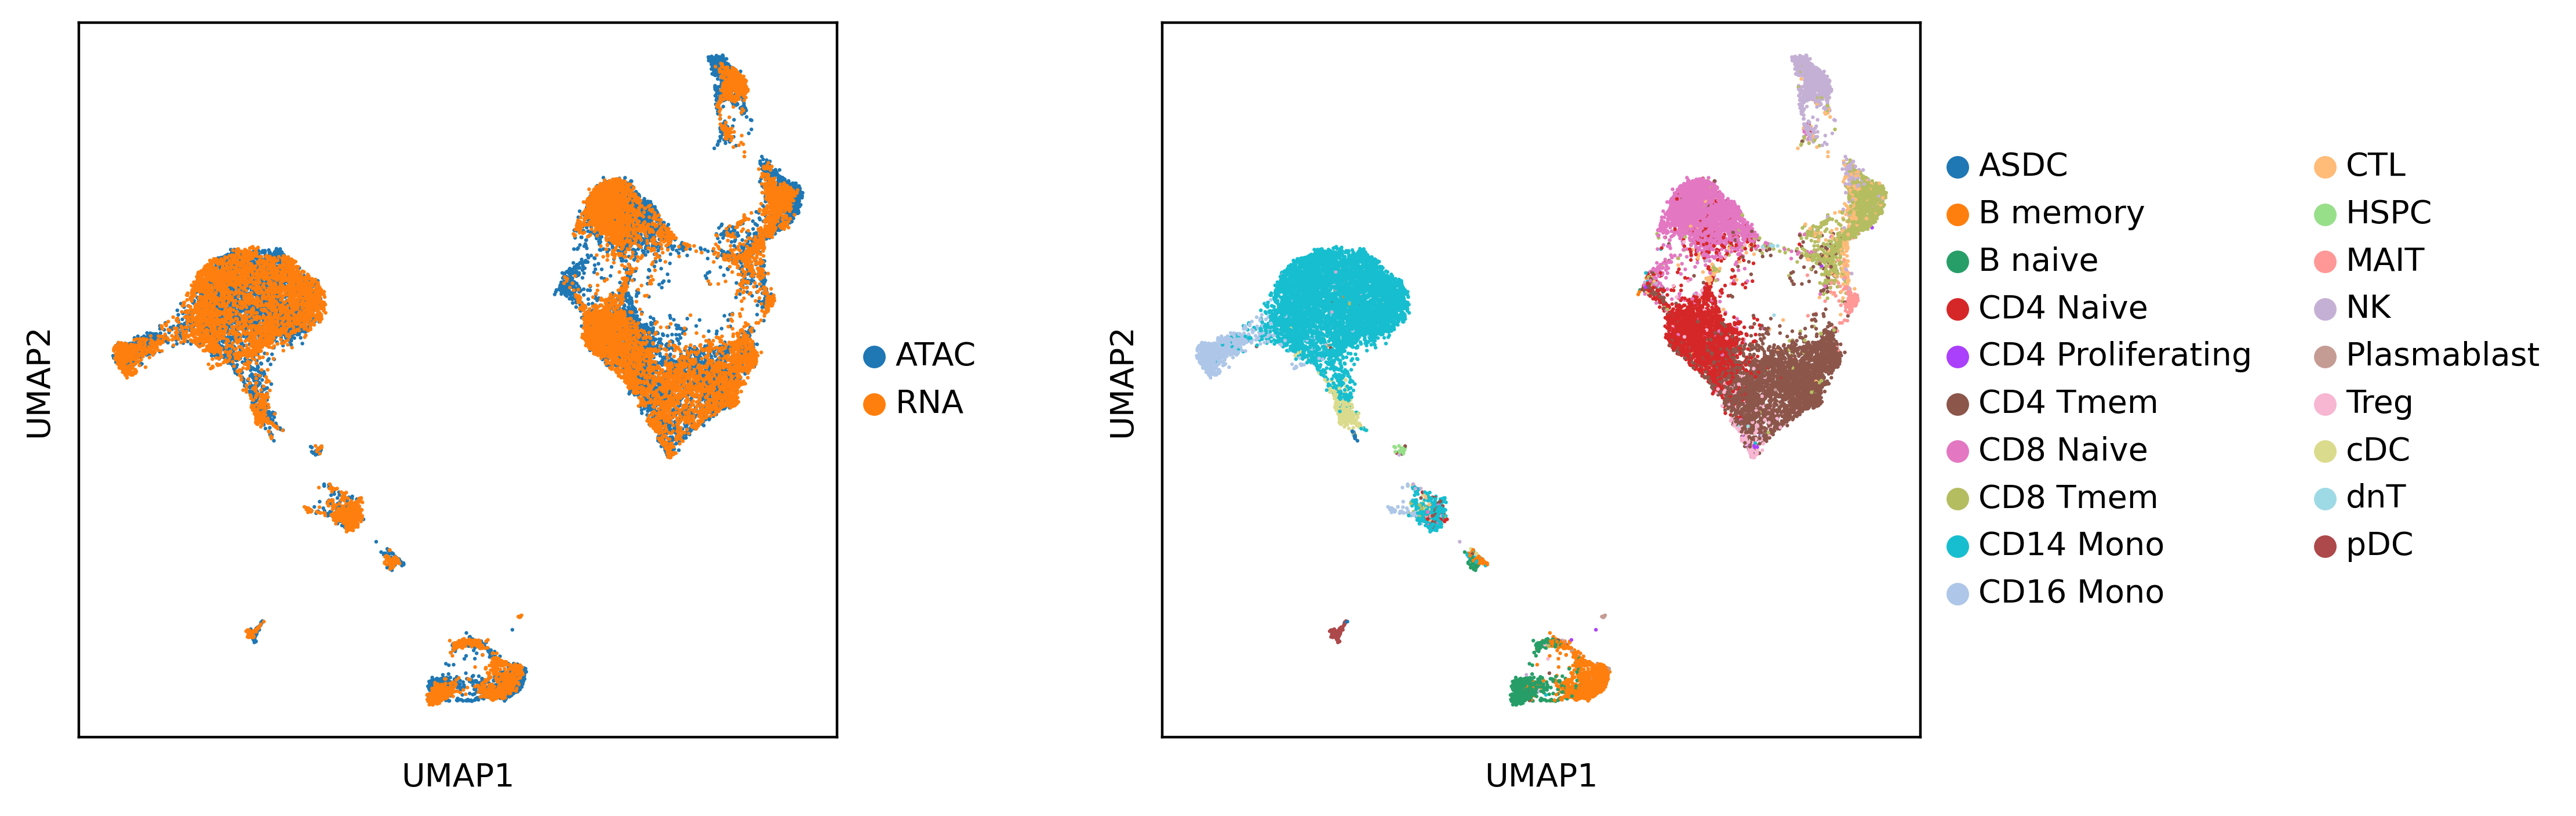

In [22]:
sc.set_figure_params(dpi=200, fontsize=10)
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'], save='uniport-pbmc.pdf', title=['',''], wspace=0.3, legend_fontsize=10)

### Evaluate the results with various scores
We evaluated the results by F1, ARI, NMI, Batch Entropy and Silhouette scores.

In [23]:
adata1 = adata[adata.obs['domain_id']=='0']
adata2 = adata[adata.obs['domain_id']=='1']
y_test = up.metrics.label_transfer(adata2, adata1, label='cell_type', rep='X_umap')
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score
print('F1:', f1_score(adata1.obs['cell_type'], y_test, average='micro'))
print('ARI:', adjusted_rand_score(adata1.obs['cell_type'], y_test))
print('NMI:', normalized_mutual_info_score(adata1.obs['cell_type'], y_test))
print('Batch Entropy:', up.metrics.batch_entropy_mixing_score(adata.obsm['X_umap'], adata.obs['domain_id']))
print('Silhouette:', up.metrics.silhouette(adata.obsm['X_umap'], adata.obs['cell_type']))

F1: 0.8490984989785949
ARI: 0.7657955254910905
NMI: 0.7411449325196692
Batch Entropy: 0.6158191095057443
Silhouette: 0.6382090449333191


### Project data after training
To project data into the latent space without training, we can set `out='project'`.

Device: cuda


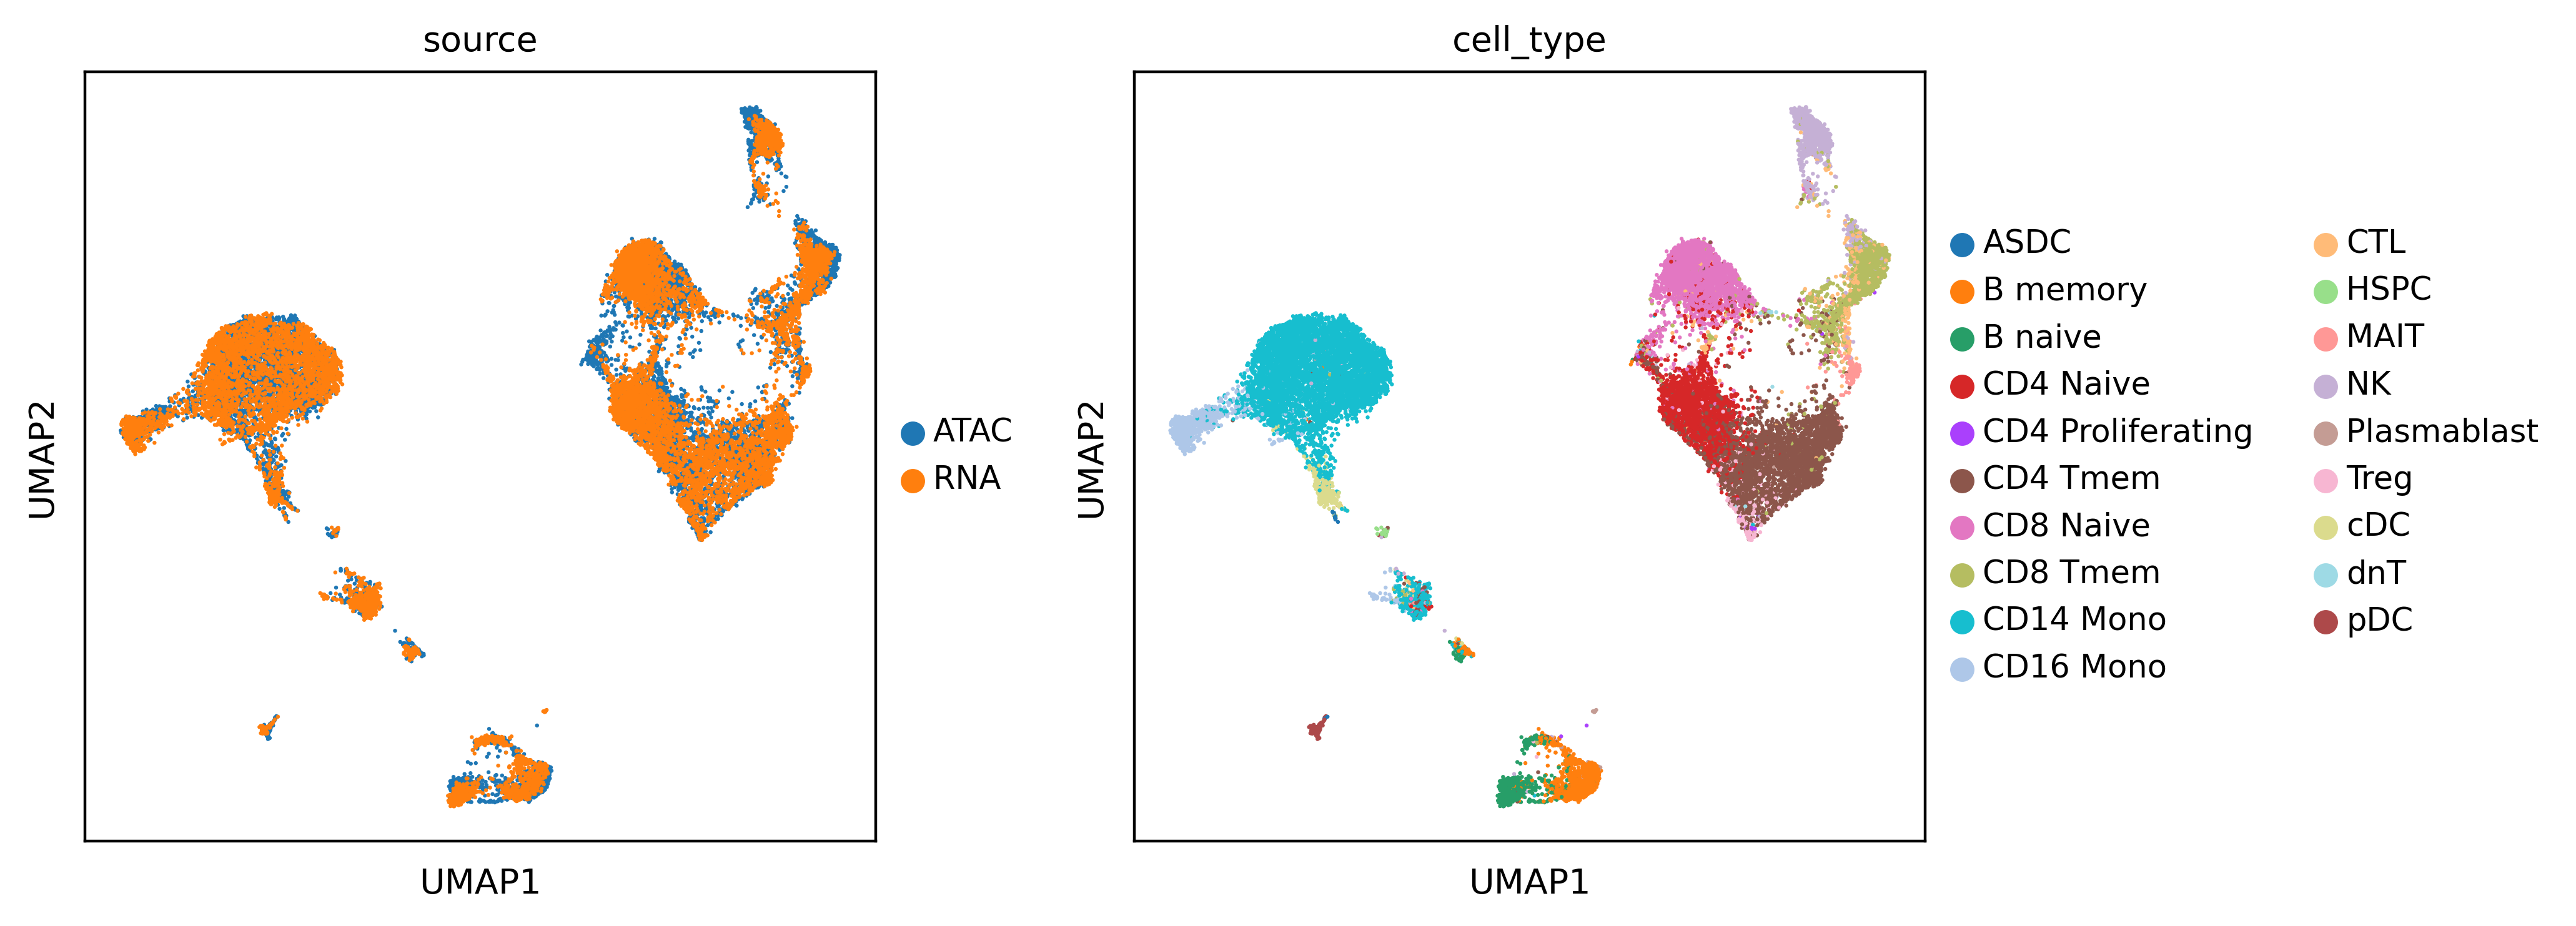

In [24]:
adata = up.Run(adata_cm=adata_cm, out='project')
sc.pp.neighbors(adata, use_rep='project')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])